In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [3]:
from src.features.engineering import *
from src.features.selection import *
from src.model.hyperparameter import *
from src.model.evaluation import *
from src.features.drivers import *
from src.features.utils import *

/Users/davidelupis/Desktop/Testing/berkabank/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Load the data
data = {
    "eod_balance_training": pd.read_csv(
        "../berkabank/primary/eod_balance_training.csv"
    ),
    "incidents": pd.read_csv("../berkabank/primary/incidents.csv"),
}

core = pd.read_csv("../berkabank/primary/core.csv")

column_mapping = {
    "incidents": {
        "account_id": "account_id",
        "incident_date": "incident_date",
        "district_id": "district_id",
        "t0": "t0",
        "t1": "t1",
    },
    "eod_balance_training": {
        "account_id": "account_id",
        "balance_date": "balance_date",
        "end_of_day_balance": "end_of_day_balance",
        "daily_amount_flow": "daily_amount_flow",
        "n_transactions": "n_transactions",
        "days_since_account_creation": "days_since_account_creation",
        "low_balance_streak": "low_balance_streak",
        "district_id": "district_id",
    },
}

eod_balance_training = (
    data["eod_balance_training"]
    .loc[
        :,
        [
            "account_id",
            "balance_date",
            "end_of_day_balance",
            "daily_amount_flow",
            "n_transactions",
        ],
    ]
    .copy()
)

eod_balance_training["flow_category"] = (
    eod_balance_training["daily_amount_flow"]
    .gt(0)
    .replace({True: "inflow", False: "outflow"})
)

eod_balance_training["daily_amount_inflow"] = eod_balance_training[
    "daily_amount_flow"
].clip(lower=0)

eod_balance_training["daily_amount_outflow"] = (
    eod_balance_training["daily_amount_flow"].clip(upper=0).abs()
)

In [5]:
index = ["account_id"]
feature_based = [
    "daily_amount_inflow",
    "daily_amount_outflow",
]
features_selected = eod_balance_training.loc[:, index + feature_based]
eod_feature_matrix = EODBFeatures(
    eod_balance_training=features_selected,
    column_mapping=column_mapping["eod_balance_training"],
).run()

eod_feature_matrix = RatioFeatures(
    df=eod_feature_matrix, n=1000, strategy="kurtosis"
).run()

----- Running EODBFeatures...
----- EODBFeatures completed.
--- Running DerivedFeatures...
--- DerivedFeatures completed.


In [6]:
feature_elimination_pipeline = FeatureEliminationPipeline(
    {
        "missing_rate": FeatureEliminationMissingRate(0.1),
        "cov": FeatureEliminationCoV(0.8),
        "kurtosis": FeatureEliminationKurtosis(3),
        "pearson": FeatureEliminationPearsonCorr(0.7),
        "vif": FeatureEliminationVIF(8),
    }
)

eod_feature_matrix = feature_elimination_pipeline.run(eod_feature_matrix, y=None)

In [7]:
eod_feature_matrix = FeatureImputer(eod_feature_matrix).run()

--- Running FeatureImputer...
--- FeatureImputer completed.


In [8]:
# Split train and validation
from sklearn.model_selection import StratifiedShuffleSplit

core_feature = core.merge(eod_feature_matrix.reset_index(), on=index).set_index(index)
X = core_feature.loc[:, eod_feature_matrix.columns]
y = core_feature["target"]

# Balance cv and validation folds
split = StratifiedShuffleSplit(n_splits=1, test_size=0.05, random_state=None)

for train_index, test_index in split.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

print(y_train.value_counts(normalize=False))
print(y_test.value_counts(normalize=False))

target
False    1283
True      758
Name: count, dtype: int64
target
False    68
True     40
Name: count, dtype: int64


In [9]:
# Parameters
from sklearn.ensemble import RandomForestClassifier

params = {
    "n_estimators": [50, 100, 200],
    "max_depth": [10, 20, 30],
    "min_samples_split": [2, 5, 10],
}
step = 0.1
scoring = "roc_auc"
cv = 3
n_jobs = -1
standard_error_threshold = 0.05
return_type = "feature_names"
num_features = "best_parsimonious"
min_features_to_select = 5

# Model GridSearch
model = RandomizedSearchCV(
    estimator=RandomForestClassifier(),
    param_distributions=params,
)

# Process core
features_processor = FeatureEliminationShap(
    model=model,
    cv=StratifiedShuffleSplit(n_splits=cv, test_size=0.1, random_state=42),
    step=step,
    scoring=scoring,
    n_jobs=n_jobs,
    standard_error_threshold=standard_error_threshold,
    return_type=return_type,
    num_features=num_features,
    check_additivity=False,
    min_features_to_select=min_features_to_select,
)

drivers = features_processor.run(X=X_train, y=y_train)

In [10]:
model = RandomForestClassifier().fit(X_train[drivers], y_train)
y_proba = model.predict_proba(X_train[drivers])
optimal_threshold = OptimalCutoffBinaryClassification(
    model=model, y_true=y_train, y_proba=y_proba
).run()

In [11]:
optimal_threshold

0.54

True Distribution of target:
target
False    68
True     40
Name: count, dtype: int64
Cutoff:optimal_threshold=0.54


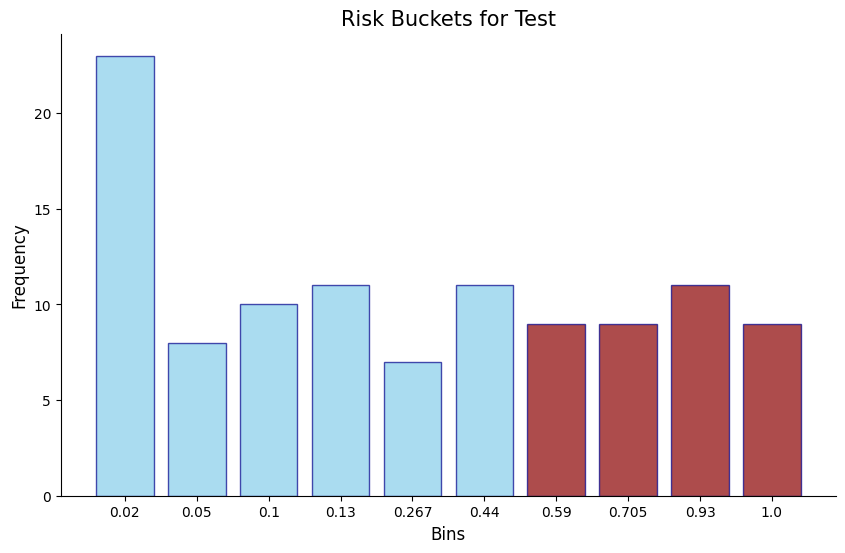

In [12]:
import matplotlib.pyplot as plt

scores = pd.Series(model.predict_proba(X_test[drivers])[:, 1])
print(f"True Distribution of target:\n{y_test.value_counts()}")
print(f"Cutoff:{optimal_threshold=}")
# Generate the data
max_q = 10
cutoff = optimal_threshold
bin_scores = pd.DataFrame(
    pd.qcut(scores, max_q + 1, labels=None, duplicates="drop")
    .value_counts()
    .sort_index()
)

# Create a figure and axes objects
fig, ax = plt.subplots(figsize=(10, 6))

# Create a bar plot
for i, val in bin_scores.iterrows():
    color = "darkred" if i.right > cutoff else "skyblue"
    ax.bar(str(i.right), val, color=color, edgecolor="darkblue", alpha=0.7)

# Set the title and labels
ax.set_title("Risk Buckets for Test", fontsize=15)
ax.set_xlabel("Bins", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)

# Remove the right and top spines
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# Display the plot
plt.show()

In [29]:
y_pred_test = model.predict_proba(X_test[drivers])
ModelEvaluationBinaryClassification(
    model=model, y_proba=y_pred_test, y=y_test, cutoff_score=optimal_threshold
).run()

Confusion Matrix:
 [[59  9]
 [15 25]]


,ROC AUC Score,Precision,Recall,F1 Score,F0.5 Score,F2 Score
Model,,,,,,
0,0.835662,0.735294,0.625,0.675676,0.710227,0.64433
